# Plot Cross Section of Glacier Ice Thickness Change
This notebook provides an example of how to plot a cross section of a single glacier for various Shared Socioeconomic Pathways (SSPs). These datasets used in this notebook can be produced by setting <em>export_binned_thickness=True</em>.

## Input data

In [1]:
glac_nos = ['15.03733']
glac_name_dict = {'15.03733':'Khumbu Glacier'}
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
# scenarios = ['ssp126']
gcm_names = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 
             'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']
output_sim_fp = '/Users/drounce/Documents/HiMAT/Output/simulations/'
fig_fp = output_sim_fp + 'figures/ind_glaciers/'
startyear = 2000 # start year
endyear = 2100   # end year
csyear = 2100    # cross section year

## Import Packages

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
import xarray as xr

try:
    import pygem
except:
    sys.path.append(os.getcwd() + '/../PyGEM/')
import pygem.pygem_modelsetup as modelsetup
import pygem_input as pygem_prms

## Dictionaries to support processing

In [3]:
scenario_colordict = {'ssp119':'#081d58', 
                      'ssp126':'#1d91c0', 
                      'ssp245':'#7fcdbb', 
                      'ssp370':'#F47A20', 
                      'ssp585':'#ED2024'}

scenario_namedict = {'rcp26':'RCP2.6',
                     'rcp45':'RCP4.5',
                     'rcp85':'RCP8.5',
                     'ssp119':'SSP1-1.9',
                     'ssp126':'SSP1-2.6',
                     'ssp245':'SSP2-4.5',
                     'ssp370':'SSP3-7.0',
                     'ssp585':'SSP5-8.5'}

## Process binned data

In [4]:
# Set up processing
glac_zbed_all = {}
glac_thick_all = {}
glac_zsurf_all = {}
glac_vol_all = {}
glac_dist = {}
years = None
for glac_no in glac_nos:

    print('\n',glac_no)
    glac_zbed_all[glac_no] = {}
    glac_thick_all[glac_no] = {}
    glac_zsurf_all[glac_no] = {}
    glac_vol_all[glac_no] = {}
    glac_dist[glac_no] = None
    
    for scenario in scenarios:

        glac_zbed_all[glac_no][scenario] = None
        glac_thick_all[glac_no][scenario] = None
        glac_zsurf_all[glac_no][scenario] = None
        glac_vol_all[glac_no][scenario] = None

        for gcm_name in gcm_names:

            ds_binned_fp = output_sim_fp + glac_no.split('.')[0].zfill(2) + '/' + gcm_name + '/' + scenario + '/binned/' 
            for i in os.listdir(ds_binned_fp):
                if i.startswith(glac_no):
                    ds_binned_fn = i
            ds_stats_fp = output_sim_fp + glac_no.split('.')[0].zfill(2) + '/' + gcm_name + '/' + scenario + '/stats/'
            for i in os.listdir(ds_stats_fp):
                if i.startswith(glac_no):
                    ds_stats_fn = i

            if glac_no in ds_stats_fn and scenario in ds_stats_fn and gcm_name in ds_stats_fn:
                ds_binned = xr.open_dataset(ds_binned_fp + ds_binned_fn)
                ds_stats = xr.open_dataset(ds_stats_fp + ds_stats_fn)
                
                years = ds_binned.year.values
                
                if glac_dist[glac_no] is None:
                    glac_dist[glac_no] = ds_binned.bin_distance[0,:].values
                    
                thick = ds_binned.bin_thick_annual[0,:,:].values
                zsurf_init = ds_binned.bin_surface_h_initial[0].values
                zbed = zsurf_init - thick[:,0]
                vol = ds_stats.glac_volume_annual[0,:].values

                if glac_zbed_all[glac_no][scenario] is None:
                    glac_thick_all[glac_no][scenario] = thick[np.newaxis,:,:]
                    glac_zbed_all[glac_no][scenario] = zbed[np.newaxis,:]
                    glac_zsurf_all[glac_no][scenario] = (zbed[:,np.newaxis] + thick)[np.newaxis,:,:]
                    glac_vol_all[glac_no][scenario] = vol[np.newaxis,:]

                else:
                    glac_thick_all[glac_no][scenario] = np.concatenate((glac_thick_all[glac_no][scenario], thick[np.newaxis,:,:]), axis=0)
                    glac_zbed_all[glac_no][scenario] = np.concatenate((glac_zbed_all[glac_no][scenario], zbed[np.newaxis,:]), axis=0)
                    glac_zsurf_all[glac_no][scenario] = np.concatenate((glac_zsurf_all[glac_no][scenario], (zbed[:,np.newaxis] + thick)[np.newaxis,:,:]), axis=0)
                    glac_vol_all[glac_no][scenario] = np.concatenate((glac_vol_all[glac_no][scenario], vol[np.newaxis,:]), axis=0)


 15.03733


## Plot cross sections along with the glacier-wide mass change

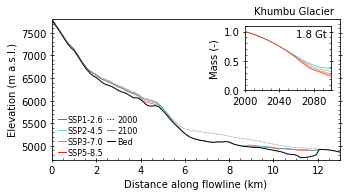

In [5]:
for glac_no in glac_nos:
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,0.65])
    ax.patch.set_facecolor('none')
    ax3 = fig.add_axes([0.67,0.32,0.3,0.3])
    ax3.patch.set_facecolor('none')

    ymin, ymax, thick_max = None, None, None
    vol_med_all = []
    
    x = glac_dist[glac_no]

    csyear_idx = np.where(years == csyear)[0][0]
    startyear_idx = np.where(years == startyear)[0][0]
    endyear_idx = np.where(years == endyear)[0][0]
        
    for nscenario, scenario in enumerate(scenarios):
        zbed_med = np.median(glac_zbed_all[glac_no][scenario],axis=0)
        zbed_std = np.std(glac_zbed_all[glac_no][scenario], axis=0)

        thick_med = np.median(glac_thick_all[glac_no][scenario],axis=0)
        thick_std = np.std(glac_thick_all[glac_no][scenario], axis=0)
        
        zsurf_med = np.median(glac_zsurf_all[glac_no][scenario],axis=0)
        zsurf_std = np.std(glac_zsurf_all[glac_no][scenario], axis=0)

        vol_med = np.median(glac_vol_all[glac_no][scenario],axis=0)
        vol_std = np.std(glac_vol_all[glac_no][scenario], axis=0)
        
        # Bed elevation and Initial surface elevation
        if scenario == scenarios[-1]:
            # If different ice thicknesses, this makes them all zero (higher scenarios often thickest ice)
            ax.fill_between(x[1:]/1000, zbed_med[1:]-20, zbed_med[1:], color='white', zorder=5+len(scenarios))
            # Plot bed elevation
            ax.plot(x/1000, zbed_med[np.arange(len(x))],
                    color='k', linestyle='-', linewidth=1, zorder=5+len(scenarios), label='zbed')
            # Plot surface elevation at start year
            ax.plot(x/1000, zsurf_med[np.arange(len(x)),startyear_idx], 
                         color='k', linestyle=':', linewidth=0.5, zorder=4+len(scenarios), label=str(startyear))

        # Surface elevation at cs_year 
        ax.plot(x/1000, zsurf_med[np.arange(len(x)), csyear_idx], 
                color=scenario_colordict[scenario], linestyle='-', linewidth=0.5, 
                zorder=4+(len(scenarios)-nscenario), label=str(csyear))

        # Normalized volume timeseries
        ax3.plot(years[startyear_idx:endyear_idx+1], 
                 vol_med[startyear_idx:endyear_idx+1] / vol_med[startyear_idx], 
                 color=scenario_colordict[scenario], 
                 linewidth=0.5, zorder=4, label=None)
        # uncertainty
        if scenario in ['ssp245', 'ssp585']:
            ax3.fill_between(years[startyear_idx:endyear_idx+1], 
                             (vol_med + vol_std)[startyear_idx:endyear_idx+1]/vol_med[startyear_idx], 
                             (vol_med - vol_std)[startyear_idx:endyear_idx+1]/vol_med[startyear_idx],
                             alpha=0.2, facecolor=scenario_colordict[scenario], label=None)

        # Record median value for printing
        vol_med_all.append(vol_med[startyear_idx])

        # ymin and ymax for bounds
        glac_idx = np.nonzero(thick_med)[0]
        if ymin is None:
            ymin = np.floor(zbed_med[glac_idx].min()/100)*100
            ymax = np.ceil(zsurf_med[:,endyear_idx].max()/100)*100
        if np.floor(zbed_med.min()/100)*100 < ymin:
            ymin = np.floor(zbed_med[glac_idx].min()/100)*100
        if np.ceil(zsurf_med[glac_idx,endyear_idx].max()/100)*100 > ymax:
            ymax = np.ceil(zsurf_med[glac_idx,endyear_idx].max()/100)*100
        # thickness max for bounds  
        if thick_max is None:
            thick_max = np.ceil(thick_med.max()/10)*10
        if np.ceil(thick_med.max()/10)*10 > thick_max:
            thick_max = np.ceil(thick_med.max()/10)*10

    # Water level
    if ymin < 0:
        water_idx = np.where(zbed_med < 0)[0]
        # Add water level
        ax.plot(x[water_idx]/1000, np.zeros(x[water_idx].shape), color='aquamarine', linewidth=1)
        
    # Cross section line (if not at end)
    if csyear < endyear:
        ax3.axvline(csyear, color='k', linewidth=0.5, linestyle='--', zorder=4)

    xmax = np.ceil(x[glac_idx].max()/1000+0.5)*1000
    if xmax/1000 > 25:
        x_major, x_minor = 10, 2
    elif xmax/1000 > 15:
        x_major, x_minor = 5, 1
    else:
        x_major, x_minor = 2, 0.5

    y_major, y_minor = 500,100

    if thick_max > 200:
        thick_major, thick_minor = 100, 20
    else:
        thick_major, thick_minor = 50, 10

    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0,xmax/1000)
    ax.xaxis.set_major_locator(MultipleLocator(x_major))
    ax.xaxis.set_minor_locator(MultipleLocator(x_minor))
    ax.yaxis.set_major_locator(MultipleLocator(y_major))
    ax.yaxis.set_minor_locator(MultipleLocator(y_minor)) 

    ax.set_ylabel('Elevation (m a.s.l.)')
    ax.set_xlabel('Distance along flowline (km)')
    ax.tick_params(axis='both', which='major', direction='inout', right=True)
    ax.tick_params(axis='both', which='minor', direction='in', right=True)

    # Add glacier name
    if glac_no in glac_name_dict.keys():
        glac_name_text = glac_name_dict[glac_no]
    else:
         glac_name_text = glac_no
    ax.text(0.98, 1.02, glac_name_text, size=10, horizontalalignment='right', 
            verticalalignment='bottom', transform=ax.transAxes)

    ax3.set_ylabel('Mass (-)')
    ax3.set_xlim(startyear, endyear)
    ax3.xaxis.set_major_locator(MultipleLocator(40))
    ax3.xaxis.set_minor_locator(MultipleLocator(10))
    ax3.set_ylim(0,1.1)
    ax3.yaxis.set_major_locator(MultipleLocator(0.5))
    ax3.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax3.tick_params(axis='both', which='major', direction='inout', right=True)
    ax3.tick_params(axis='both', which='minor', direction='in', right=True)
    vol_norm_gt = np.median(vol_med_all) * pygem_prms.density_ice / 1e12

    if vol_norm_gt > 10:
        vol_norm_gt_str = str(int(np.round(vol_norm_gt,0))) + ' Gt'
    elif vol_norm_gt > 1:
        vol_norm_gt_str = str(np.round(vol_norm_gt,1)) + ' Gt'
    else:
        vol_norm_gt_str = str(np.round(vol_norm_gt,2)) + ' Gt'
    ax3.text(0.95, 0.95, vol_norm_gt_str, size=10, horizontalalignment='right', 
            verticalalignment='top', transform=ax3.transAxes)

    # Legend
    leg_lines = []
    leg_labels = [scenario_namedict[x] for x in scenarios]
    for nscenario, scenario in enumerate(scenarios):
        line = Line2D([0,1],[0,1], color=scenario_colordict[scenario], linewidth=1)
        leg_lines.append(line)

    # add years
    line = Line2D([0,1],[0,1], color='k', linestyle=':', linewidth=1)
    leg_lines.append(line)
    leg_labels.append(str(startyear))
    line = Line2D([0,1],[0,1], color='grey', linestyle='-', linewidth=1)
    leg_lines.append(line)
    leg_labels.append(str(csyear))
    if zbed_med.min() < 0:
        line = Line2D([0,1],[0,1], color='aquamarine', linewidth=1)
        leg_lines.append(line)
        leg_labels.append('Sea level')
    line = Line2D([0,1],[0,1], color='k', linewidth=1)
    leg_lines.append(line)
    leg_labels.append('Bed')

    ax.legend(leg_lines, leg_labels, loc=(0.02,0.02), fontsize=8, labelspacing=0.25, handlelength=1, 
              handletextpad=0.25, borderpad=0, ncol=2, columnspacing=0.5, frameon=False)

    # Save figure
    fig_fn = (glac_no + '_profile_' + str(csyear) + '_ssps.png')
    fig.set_size_inches(4,3)
    fig.patch.set_facecolor('white')
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300)
    plt.show()

## Considerations
- For large glaciers, the changes between scenarios can be challenging to see in cross sections because the change in ice thickness is small compared to the elevation range. In these cases, you may want to plot the ice thickness change in a separate subplot (if this is what you'd like to highlight) or zoom in on an elevation range of interest.